# 多層パーセプトロンによる分類

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

## irisデータセットの分類

In [3]:
from sklearn.datasets import load_iris
data = load_iris()

In [4]:
## 自分で用意したデータセットを使う場合は，このセルのプログラムを使ってください．
## ・データは，以下のような形式のcsvファイルを「data.csv」として用意する
## sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
## 5.1,3.5,1.4,0.2,Iris-setosa
## 4.9,3.0,1.4,0.2,Iris-setosa
## 7.0,3.2,4.7,1.4,Iris-versicolor
## 6.4,3.2,4.5,1.5,Iris-versicolor
## 6.3,3.3,6.0,2.5,Iris-virginica
## 5.8,2.7,5.1,1.9,Iris-virginica
## ・CSVファイルの最初の行をヘッダとする
## ・CSVファイルで一番右の列をクラスとする
#
#import pandas as pd
#df = pd.read_csv("data.csv", header=0)
#target_column = df.columns.values.tolist()[-1]
#target2id = dict((c, i) for i, c in enumerate(set(df[target_column].values.tolist())))
#
#data = {}
#data['feature_names'] = df.columns.values.tolist()[:-1]
#data['target_names'] = list([c for c, i in sorted(target2id.items(), key=lambda x: x[1])])
#data['target'] = np.array([target2id[c] for c in df[target_column].values.tolist()])
#data['data'] = np.array(df[data['feature_names']].values.tolist())

In [5]:
data['data'][48:53]

array([[5.3, 3.7, 1.5, 0.2],
       [5. , 3.3, 1.4, 0.2],
       [7. , 3.2, 4.7, 1.4],
       [6.4, 3.2, 4.5, 1.5],
       [6.9, 3.1, 4.9, 1.5]])

In [6]:
data['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
data['target'][48:53]

array([0, 0, 1, 1, 1])

クラス0が `'setosa'`, クラス1が `'versicolor'`, クラス2が `'virginica'` というアヤメの種類

In [8]:
data['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [9]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(np.arange(len(data['data'])), test_size=0.3, random_state=42)
train_X = torch.tensor(data['data'][train_idx], dtype=torch.float)
train_y = torch.tensor(data['target'][train_idx], dtype=torch.long)
test_X = torch.tensor(data['data'][test_idx], dtype=torch.float)
test_y = torch.tensor(data['target'][test_idx], dtype=torch.long)

In [10]:
print(len(train_X), len(train_y))
print(len(test_X), len(test_y))

105 105
45 45


In [11]:
class MLP(nn.Module):
    def __init__(self, xdim, hdim, ydim):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(xdim, hdim)
        self.linear2 = nn.Linear(hdim, ydim)
        
    def forward(self, X):
        a1 = self.linear1(X)
        z1 = F.relu(a1)
        a2 = self.linear2(z1)
        return a2

In [12]:
mlp = MLP(4, 3, 3)
optimizer = optim.SGD(mlp.parameters(), lr = 0.1)
loss_history = []
for epoch in range(300):
    optimizer.zero_grad()
    a = mlp(train_X)
    loss = F.cross_entropy(a, train_y)
    loss.backward()
    optimizer.step()
    loss_history.append(loss)

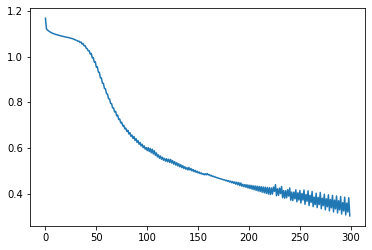

In [13]:
plt.plot(loss_history)

In [14]:
a = mlp(test_X)
pred_proba = F.softmax(a, dim=1)
pred_y = torch.argmax(pred_proba, dim=1)
print(pred_y)
print(pred_y == test_y)
accuracy = (pred_y == test_y).sum() / float(len(pred_y))
print(accuracy)

tensor([2, 0, 2, 2, 1, 0, 1, 2, 2, 1, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 1, 0, 0],
       grad_fn=<NotImplemented>)
tensor([False,  True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True])
tensor(0.8667)


In [15]:
from sklearn.metrics import classification_report

In [16]:
print(classification_report(test_y.data, pred_y.data, target_names=data['target_names']))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      0.54      0.70        13
   virginica       0.68      1.00      0.81        13

    accuracy                           0.87        45
   macro avg       0.89      0.85      0.84        45
weighted avg       0.91      0.87      0.86        45



## 記事ジャンルの分類

### 訓練データの読み込みとモデルの学習

In [17]:
data = [l.strip().split('\t') for l in open('train.tsv')]
sents, labels = list(zip(*data))
print(sents[0])
print(labels[0])

【Sports Watch】安藤美姫“日本の人の声は気になったり、今でも怖い” 日本テレビ「バンクーバー2010」（27日放送）には女子フィギュアスケートで活躍した安藤美姫＆鈴木明子が出演、大舞台での演技から一夜明け、その心境を語った。  「トリノと比べると、落ち着いて一日一日を過ごせて、メダルが目標だったので、残念だったんですけど、演技自体はオリンピックの舞台でミスなく終われて幸せでした。スケートやっててよかったな。初めて心から幸せだなと思えた」という安藤に、パーソナルベストを出し8位入賞を果たした鈴木明子は「無事に終わってホッとしています。想像していた通り、緊張するだろうなと思って入ってきていたので、予想通りすごい緊張感はあったんですけど、会場の空気感を目で見て、耳で感じて、肌でも感じられるようにしたいなと思って、そこから滑り出したいと思っていた」と振り返った。  また、日本女子フィギュア勢で唯一トリノ五輪を経験している安藤は、前大会と比較したプレッシャーの差を訊かれると、「日本の人の声は気になったり、今でも怖い。どうやって言われるだろうとか。でも、そういうものを全日本で出してしまってジャンプの失敗に繋がったので、今回は一つの作品として、とにかく難易度を下げてでも一つの作品として滑りたかった」と明かし、そのプレッシャーの重さを感じさせた。
sports


In [18]:
import MeCab
tagger = MeCab.Tagger('-Owakati')
tokenized_sents = [tagger.parse(sent) for sent in sents]

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=2, max_df=0.5, max_features=1000)
tfs = vectorizer.fit_transform(tokenized_sents)

In [20]:
print(vectorizer.get_feature_names())

['00', '000', '01', '05', '06', '10', '100', '1000', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2009', '2010', '2011', '2012', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '300', '31', '32', '35', '40', '48', '50', '500', '60', 'akb', 'android', 'arrows', 'au', 'cm', 'com', 'cpu', 'facebook', 'fi', 'galaxy', 'gb', 'ghz', 'google', 'hd', 'htc', 'http', 'ipad', 'iphone', 'is', 'isw', 'it', 'jp', 'livedoor', 'lte', 'mah', 'max', 'mbps', 'mm', 'movie', 'news', 'ntt', 'on', 'one', 'optimus', 'os', 'pc', 'phone', 'play', 'salon', 'sh', 'smaxjp', 'softbank', 'sports', 'store', 'sx', 'tbs', 'the', 'tv', 'twitter', 'watch', 'web', 'wi', 'xi', 'xperia', 'ああ', 'あげ', 'あっ', 'あと', 'あなた', 'あの', 'あまり', 'あり', 'あれ', 'いい', 'いう', 'いえ', 'いか', 'いかが', 'いき', 'いく', 'いけ', 'いただき', 'いっ', 'いつ', 'いつも', 'いろいろ', 'うち', 'うまく', 'おく', 'おすすめ', 'および', 'おり', 'お知らせ', 'お金', 'かけ', 'かなり', 'かも', 'かわいい', 'ください', 'くらい', 'くる', 'くれ', 'くれる', 'けど', 'こう', 'ここ', 'こそ', 'こちら', 'この', 'これ', 'これから', 'こ

In [21]:
# クラスの文字列を0, 1, 2, ...のID番号に変換する
label2id = dict((c, i) for i, c in enumerate(set(labels)))
label_ids = np.array([label2id[c] for c in labels])

In [22]:
train_X = torch.tensor(tfs.todense(), dtype=torch.float)
train_y = torch.tensor(label_ids, dtype=torch.long)

In [23]:
class MLP(nn.Module):
    def __init__(self, xdim, hdim, ydim):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(xdim, hdim)
        self.linear2 = nn.Linear(hdim, ydim)
        
    def forward(self, X):
        a1 = self.linear1(X)
        z1 = F.relu(a1)
        a2 = self.linear2(z1)
        return a2

In [24]:
mlp = MLP(len(vectorizer.get_feature_names()), 3, 2)
optimizer = optim.SGD(mlp.parameters(), lr = 0.1)
loss_history = []
for epoch in range(300):
    optimizer.zero_grad()
    a = mlp(train_X)
    loss = F.cross_entropy(a, train_y)
    loss.backward()
    optimizer.step()
    loss_history.append(loss)

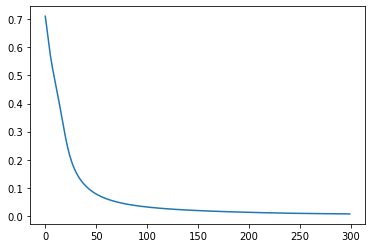

In [25]:
plt.plot(loss_history)

### テストデータの読み込みと予測

In [26]:
data = [l.strip().split('\t') for l in open('test.tsv')]
test_sents, test_labels = list(zip(*data))
tokenized_test_sents = [tagger.parse(sent) for sent in test_sents]
test_tfs = vectorizer.transform(tokenized_test_sents)
test_label_ids = np.array([label2id[c] for c in test_labels])

In [27]:
test_X = torch.tensor(test_tfs.todense(), dtype=torch.float)
test_y = torch.tensor(test_label_ids, dtype=torch.long)

In [28]:
a = mlp(test_X)
pred_proba = F.softmax(a, dim=1)
pred_y = torch.argmax(pred_proba, dim=1)
print(pred_y)
print(pred_y == test_y)
accuracy = (pred_y == test_y).sum() / float(len(pred_y))
print(accuracy)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], grad_fn=<NotImplemented>)
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  Tr